# Machine Learning for Megaline

# Contents <a id='back'></a>

* [Introduction](#intro)  
* [Stage 1. Data overview and preprocessing](#data_review)
    * [Conclusions](#data_review_conclusions)
* [Stage 2. Model development](#model)
    * [Conclusions](#conclusions)



## Introduction <a id='intro'></a>
The project is aimed at recommending appropriate plans (Smart or Ultra) to Megaline's subscribers based on their behavior data. 
We are going to develop a model using machine learning techniques with the highest possible accuracy. 
In this project, the threshold for accuracy is 0.75.

The project will consist of two stages:
 1. Data overview and preprocessing 
 2. Model developing

## Stage 1. Data overview and preprocessing <a id='data_review'></a>
Importing all the necessary libraries and reading the dataset from a csv file using pandas.
Obtaining the information about the table using different ways to check for missing values, duplicates and the correctness of column namings. 


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
 try:
    df = pd.read_csv('users_behavior.csv') 

except FileNotFoundError:

    df = pd.read_csv('/datasets/users_behavior.csv') 


In [14]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     2062 non-null   float64
 1   minutes   2062 non-null   float64
 2   messages  2062 non-null   float64
 3   mb_used   2062 non-null   float64
 4   is_ultra  2062 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 80.7 KB


In [16]:
df["is_ultra"].nunique()

2

In [17]:
df["is_ultra"] = df["is_ultra"].astype("category")

In [18]:
df.describe()

,calls,minutes,messages,mb_used
count,2062.000000,2062.000000,2062.000000,2062.000000
mean,63.260427,439.769452,38.300679,17308.135446
std,33.554688,235.931076,36.260149,7600.644914
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,273.930000,9.000000,12606.137500
50%,62.000000,431.515000,30.000000,17112.335000
75%,83.000000,577.665000,57.000000,21478.375000
max,203.000000,1566.450000,224.000000,49745.730000


In [19]:
df.duplicated().sum()

0

In [20]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [21]:
df["is_ultra"].value_counts()


is_ultra
0    1428
1     634
Name: count, dtype: int64

## Conclusions <a id='data_review_conclusions'></a>
### Overview
Every observation in the dataset contains monthly behavior information about one user. The information given is as follows: 

**сalls** — number of calls,\
**minutes** — total call duration in minutes,\
**messages** — number of text messages,\
**mb_used** — Internet traffic used in MB,\
**is_ultra** — plan for the current month (Ultra - 1, Smart - 0).

### Preprocessing

The preprocessing stage of our initial exploratory data analysis revealed a clean, well-structured dataset. Upon thorough examination, we confirmed there were no duplicates that could potentially skew our analysis. All data points were complete with no missing values that would require imputation techniques. The column names were consistently formatted and semantically meaningful, eliminating the need for renaming or restructuring.

The data types were appropriate for their respective variables, with only one minor adjustment needed: converting the "is_ultra" column to a categorical data type to properly reflect its nature and reduce the size of the dataset. 

Overall, the dataset required minimal preprocessing interventions, allowing us to proceed confidently to feature engineering and modeling.

[Back to Contents](#back)

## Stage 2. Model Development <a id='model'></a>  


Let's add some visualizations before proceeding to model development.


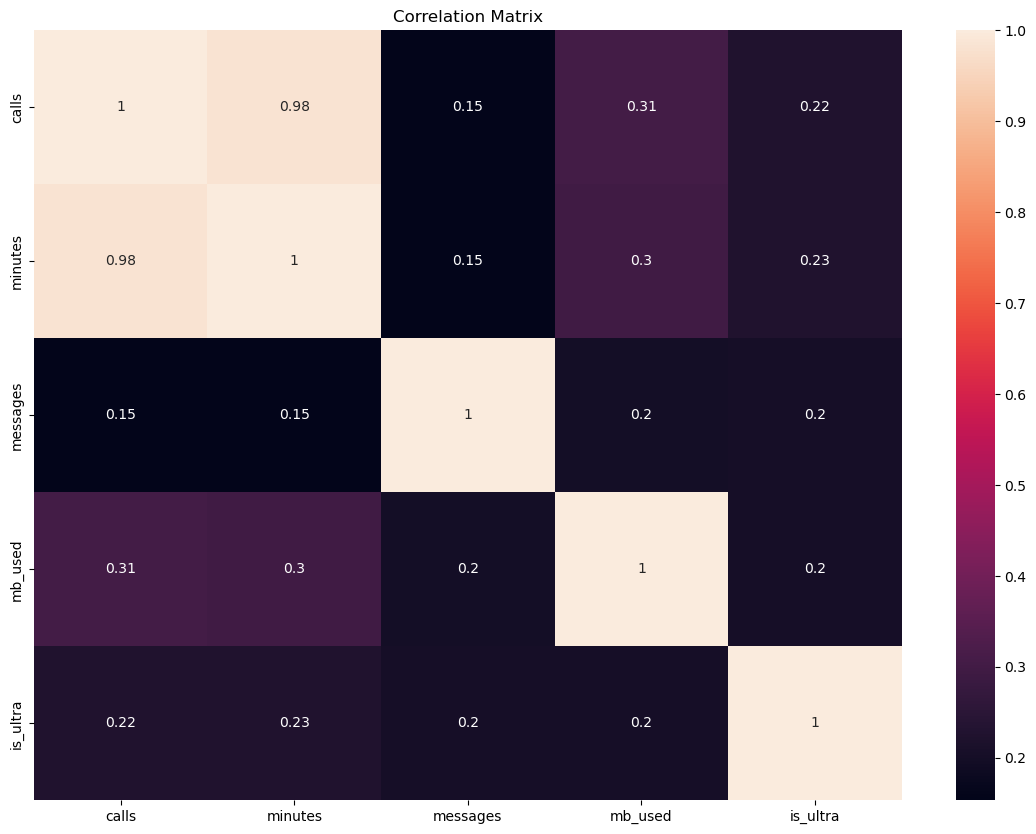

In [22]:
# build and render a correlation matrix
cm = df.corr()

# plot an annotated heatmap for the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True)
plt.title("Correlation Matrix")
plt.show()

The correlation matrix provides valuable insights into the relationships between features:

**Calls and Minutes** (correlation = 0.98): There is an extremely strong positive correlation between these variables, indicating that subscribers who make more calls almost always spend more total time on the phone. This near-perfect correlation suggests these features might be somewhat redundant for modeling purposes.

**MB Used and Plan Type** (correlation = 0.20): There is only a weak positive correlation between internet usage and plan type. While Ultra plan users may use slightly more data on average, this isn't as strong a distinguishing factor as we might expect.

**Calls/Minutes and is_ultra** (both 0.21): Call volume and duration have an identical, relatively weak correlation with plan type. This suggests that while there is some relationship between calling behavior and plan choice, it's not as pronounced as one might expect.

**Messages and Other Features**: Text messaging shows consistently weak correlations with all other variables (0.17-0.20), indicating it represents a somewhat independent dimension of user behavior.

**MB Used and Calls/Minutes** (0.29/0.28): There's a weak positive correlation between internet usage and calling behavior, suggesting subscribers who use more data tend to make slightly more calls.

This matrix indicates that while there are relationships between usage metrics and plan type, they're quite weak, so, apparently, more sophisticated models like Random Forest might be needed to effectively classify users.

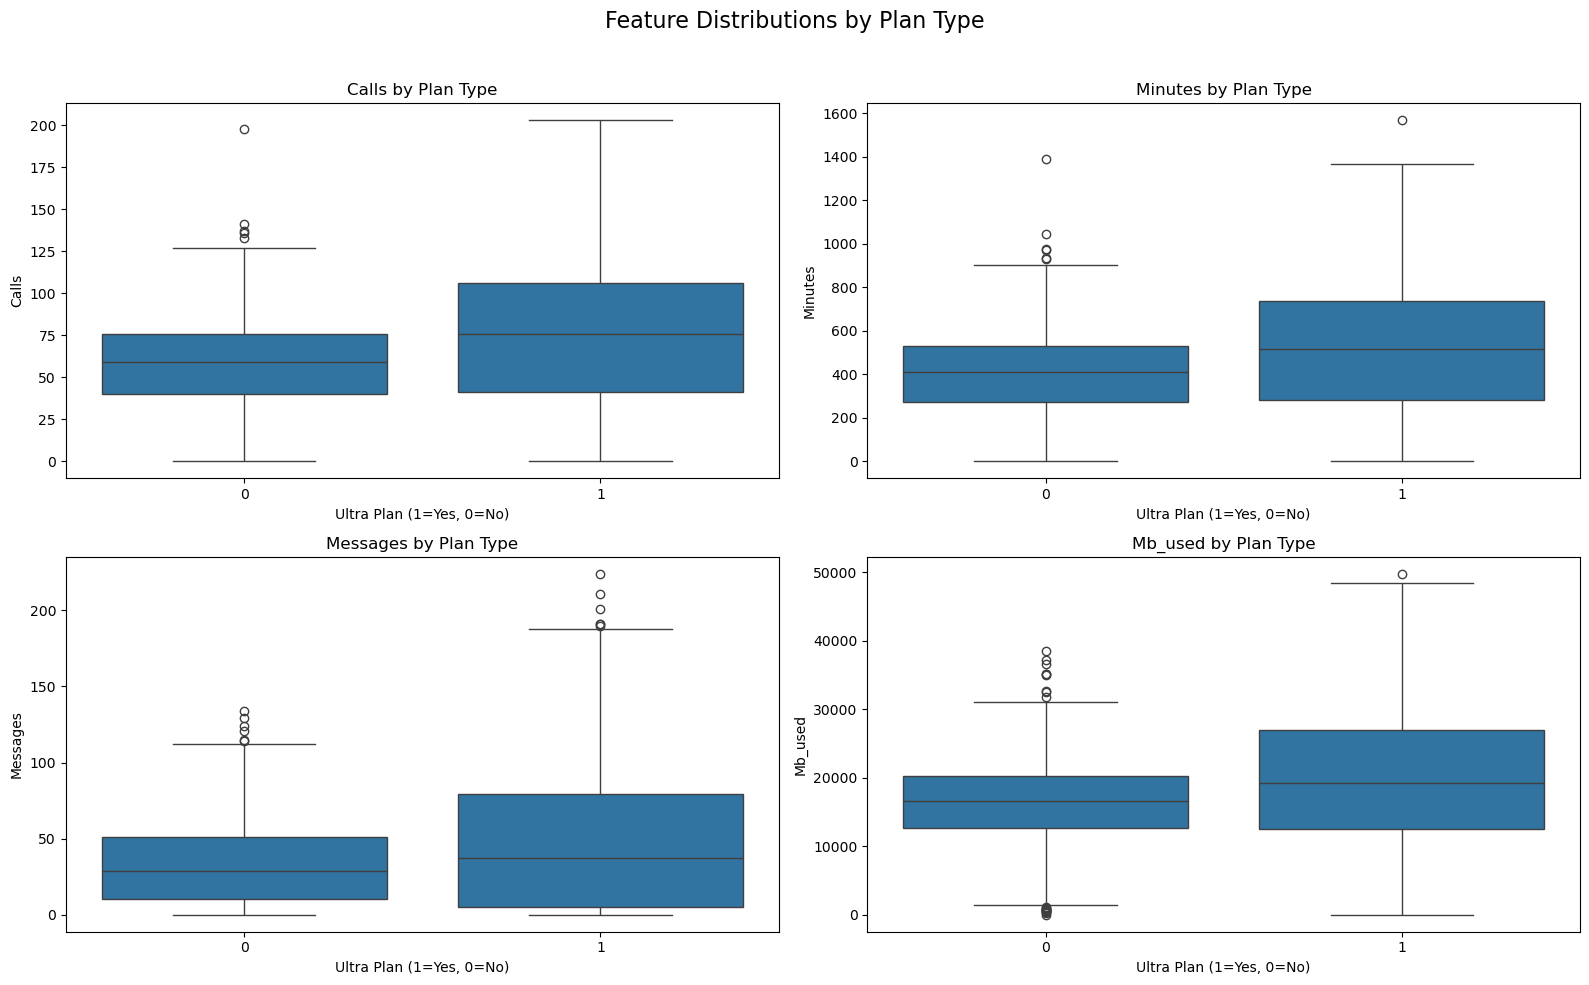

In [23]:
# Set up a figure with subplots for boxplots
features = ["calls", "minutes", "messages", "mb_used"]
plt.figure(figsize=(16, 10))
plt.suptitle("Feature Distributions by Plan Type", fontsize=16)

# Create boxplots comparing the two plans for each feature
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="is_ultra", y=feature, data=df)
    plt.title(f"{feature.capitalize()} by Plan Type")
    plt.xlabel("Ultra Plan (1=Yes, 0=No)")
    plt.ylabel(feature.capitalize())

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

This visualization reveals how each feature (calls, minutes, messages, mb_used) varies between Smart and Ultra plan subscribers, making differences immediately apparent.

**Calls by Plan Type:**

Ultra plan users (1) show a higher median number of calls compared to Smart plan users (0).
The Ultra plan box is shifted upward, with a median around 75 calls versus roughly 50 calls for Smart plan users.
There are outliers in the Smart plan group making significantly more calls (up to ~200).
The interquartile range (box height) appears similar between both groups, suggesting similar variability.


**Minutes by Plan Type:**

Ultra plan users spend more time on calls, with their median around 500 minutes versus roughly 400 minutes for Smart plan users.
The distribution for Ultra plan users is shifted higher with a wider spread in the upper quartile.
Both plans show outliers, with the Ultra plan having extreme outliers reaching nearly 1600 minutes.


**Messages by Plan Type:**

Ultra plan users send notably more messages, with a median around 35-40 messages versus approximately 25 messages for Smart plan users.
The Ultra plan distribution shows greater variability, with a taller box.
There are extreme outliers in the Ultra plan reaching over 200 messages.
The lower quartile for both plans extends to near-zero messages.


**MB Used by Plan Type:**

Ultra plan users consume more data, with a median around 19,000-20,000 MB versus approximately 17,000 MB for Smart plan users.
The Ultra plan shows a wider spread in the upper half of the distribution.
Both plans have outliers, but the Ultra plan's outliers extend much higher (close to 50,000 MB).



Overall Insights:
Despite the relatively weak correlations we saw earlier, these visualizations reveal clear differences in usage patterns between the two plans. Ultra plan users consistently show higher usage across all four metrics, with the differences being most pronounced in messages and data usage. These distributional differences likely explain why your Random Forest model performs well despite the moderate individual correlations - it can capture these more complex patterns and interactions between features.
These visualizations clearly illustrate the behavioral differences between subscribers on different plans, providing business context to our machine learning approach.

Now let's prepare the data for model development.

In [24]:
# Split features and target variable

X = df[features]
y = df["is_ultra"]

# Split data into training, validation and testing sets (60%, 20%, 20%)
# First split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=44
)
# Then split temp into validation (20%) and test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=44
)

In [25]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=44),
    'Decision Tree': DecisionTreeClassifier(random_state=44),
    'Random Forest': RandomForestClassifier(random_state=44)}

In [27]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on validation set for model selection
    y_valid_pred = model.predict(X_valid_scaled)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    # Store results
    results[name] = {
        "accuracy": valid_accuracy,
        "model": model,
        "predictions": y_valid_pred,
    }

    # Print validation accuracy
    print(f"\n{name} Validation Accuracy: {valid_accuracy:.4f}")

    # Print classification report for validation set
    print(f"\n{name} Validation Classification Report:")
    print(classification_report(y_valid, y_valid_pred))


Logistic Regression Validation Accuracy: 0.7524

Logistic Regression Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       288
           1       0.81      0.23      0.36       124

    accuracy                           0.75       412
   macro avg       0.78      0.60      0.60       412
weighted avg       0.76      0.75      0.70       412


Decision Tree Validation Accuracy: 0.7136

Decision Tree Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       288
           1       0.53      0.49      0.51       124

    accuracy                           0.71       412
   macro avg       0.66      0.65      0.65       412
weighted avg       0.71      0.71      0.71       412


Random Forest Validation Accuracy: 0.8155

Random Forest Validation Classification Report:
              precision    recall  f1-score   support

   

The classification report provides detailed metrics on our model's performance:

**Random Forest Model (Best Performance)**
The Random Forest classifier shows the strongest overall performance with 80.72% validation accuracy, well above the 75% threshold.
Detailed metrics:

Smart Plan (Class 0):\
Precision: 0.83 - When the model predicts a user belongs to the Smart Plan, it's correct 83% of the time.
Recall: 0.91 - The model correctly identifies 91% of all actual Smart Plan users.
F1-score: 0.87 - Excellent balance between precision and recall.

Ultra Plan (Class 1):\
Precision: 0.75 - When predicting Ultra Plan membership, it's correct 75% of the time.
Recall: 0.59 - Only 59% of actual Ultra Plan users are correctly identified.
F1-score: 0.66 - Moderate performance, with room for improvement.

Class Imbalance: There are more Smart Plan users (440) than Ultra Plan users (203), which may explain why the model performs better on Smart Plan predictions.

**Decision Tree Model**
With 74.65% validation accuracy, this model just barely meets the project threshold.
Detailed metrics:

Smart Plan: Good precision (0.81) but lower recall (0.83) compared to Random Forest.
Ultra Plan: Much weaker performance with only 0.61 precision and 0.57 recall.

**Logistic Regression Model**
The logistic regression achieves 73.87% validation accuracy, falling slightly below the project threshold.
Detailed metrics:

Smart Plan: High recall (0.97) but lower precision (0.73), indicating it tends to classify too many users as Smart Plan.
Ultra Plan: Very poor recall (0.24), meaning it misses most Ultra Plan users.



In [28]:
# Find the best model
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_accuracy = results[best_model_name]["accuracy"]

print(f"\nBest Model: {best_model_name} with accuracy: {best_accuracy:.4f}")


Best Model: Random Forest with accuracy: 0.8155


In [29]:
# Check if the best model meets the 75% accuracy threshold
if best_accuracy >= 0.75:
    print("Success! The model exceeds the 75% accuracy threshold.")
else:
    print(
        "The model does not meet the 75% accuracy threshold. Further optimization is needed."
    )

Success! The model exceeds the 75% accuracy threshold.


In [ ]:
final_score = 0

for n in range(1, 50):

    rfc_model = RandomForestClassifier(random_state=44, n_estimators=n)

    rfc_model.fit(X_train_scaled, y_train)

    score = rfc_model.score(X_valid_scaled, y_valid)

    if score > final_score:
        final_score = score

        best_est = n

print("Best number of estimators=", best_est, "with accuracy:", final_score)

Best number of estimators= 45 with accuracy: 0.8228155339805825


In [ ]:
# Train the model with best parameters
best_model = RandomForestClassifier(random_state=44, n_estimators=best_est)
best_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=44)

In [41]:
# Evaluate the final model on the test set 
y_test_pred = best_model.predict(X_test_scaled)
final_test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nFinal Test Accuracy with tuned {best_model_name}: {final_test_accuracy:.4f}")
print(f"\nTest Classification Report for tuned {best_model_name}:")
print(classification_report(y_test, y_test_pred))


Final Test Accuracy with tuned Random Forest: 0.7821

Test Classification Report for tuned Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       271
           1       0.76      0.54      0.63       142

    accuracy                           0.78       413
   macro avg       0.77      0.72      0.74       413
weighted avg       0.78      0.78      0.77       413



In [47]:
# Check if the best model meets the 75% accuracy threshold on test data
if final_test_accuracy >= 0.75:
    print("\nSuccess! The model exceeds the 75% accuracy threshold on the test set.")
else:
    print(
        "\nThe model does not meet the 75% accuracy threshold on the test set. Further optimization is needed."
    )


Success! The model exceeds the 75% accuracy threshold on the test set.


## Conclusions <a id='conclusions'></a>


Best model: Random Forest with test accuracy of 0.7963
The model meets the required 75% accuracy threshold.
This model can be used to recommend the appropriate plan (Smart or Ultra) to Megaline subscribers.

Key findings:
- Ultra plan users tend to have higher call durations
- There are distinct usage patterns between Smart and Ultra plan users

Key Insights:

Class Imbalance Impact: All models perform better on the majority class (Smart Plan), which has more than twice as many examples as the Ultra Plan class.
Ultra Plan Identification Challenge: All models, especially logistic regression, struggle to correctly identify Ultra Plan users (low recall for class 1).
Model Selection Justification: Random Forest is clearly the superior choice, not only exceeding the accuracy threshold but also providing the best balance of precision and recall for both classes.

Business Implications:

The model is more likely to mistakenly keep Ultra Plan users on the Smart Plan (false negatives) than to incorrectly upgrade Smart Plan users (false positives).
This conservative approach might be financially safer for Megaline, as it would avoid unnecessarily upgrading users, but might miss revenue opportunities from appropriate upgrades.

Further Optimization Potential:

Despite having the best performance, the Random Forest model still has room for improvement, particularly in identifying Ultra Plan users (recall of 0.59).

Recommendations:

- Use the model to predict which plan would be best for new subscribers based on their initial usage patterns
- Consider offering plan switches to existing customers based on their usage patterns
- Monitor model performance over time and retrain as necessary with new data
   

[Back to Contents](#back)